## Gaussian processes

**Gaussian processes** are distributions over functions $f(x)$ of which the distribution is defined by a mean function $m(x)$ and positive definite covariance function $k(x,x′)$, with $x$ the function values and $(x,x′)$ all possible pairs in the input domain :

$f(x)∼GP(m(x),k(x,x′))$

where for any finite subset $X={x_1 ... x_n}$
of the domain of $x$, the marginal distribution is a multivariate Gaussian distribution:


$f(X)∼N(m(X),k(X,X))$

with mean vector $μ=m(X)$
and covariance matrix $Σ=k(X,X)$. 


Instead of inferring a distribution over the parameters of a parametric function Gaussian processes can be used to infer a distribution over functions directly. A Gaussian process defines a prior over functions. After having observed some function values it can be converted into a posterior over functions. Inference of continuous function values in this context is known as GP regression but GPs can also be used for classification.


**Another definition**: A Gaussian process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and where the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian:

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})\tag{1}\label{eq1}$$


In [174]:
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
#

### Covariance function as prior

To sample functions from the Gaussian process we need to define the **mean and covariance** functions. 
The covariance function $k(x_a,x_b)$ models the joint variability of the Gaussian process random variables. It returns the modelled covariance between each pair in xa and xb


The specification of this covariance function, also known as the kernel function, implies a distribution over functions $f(x)$. By choosing a specific kernel function k it is possible to set prior information on this distribution. This kernel function needs to be positive-definite in order to be a valid covariance function. 

Here, we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel:

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)\tag{10}
$$

The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic kernel). 

In [175]:
def kernel_rbf(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

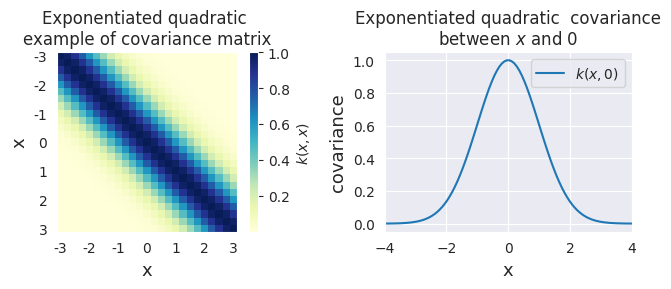

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=100)
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)

Σ = kernel_rbf(X, X)

# Plot covariance matrix
im = ax1.imshow(Σ, cmap=cm.YlGnBu)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponentiated quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

# Show covariance with X=0
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0]])
Σ0 = kernel_rbf(X, zero)
# Make the plots
ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('covariance', fontsize=13)
ax2.set_title((
    'Exponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax2.set_ylim([0, 1.1])
ax2.set_xlim(*xlim)
ax2.legend(loc=1)

fig.tight_layout()
plt.show()


### Covariance function as prior


In practice we can't just sample a full function evaluation f from a Gaussian process distribution since that would mean evaluating $m(x)$ and $k(x,x′)$ at an infinite number of points since x can have an infinite domain . We can however sample function evaluations $y$ of a function $f$ drawn from a Gaussian process at a finite, but arbitrary, set of points $X: y=f(X)$.

A finite dimensional subset of the Gaussian process distribution results in a marginal distribution that is a Gaussian distribution $y∼N(μ,Σ)$ with mean vector $μ=m(X)$, covariance matrix $Σ=k(X,X)$.


In [177]:
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample

# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = kernel_rbf(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

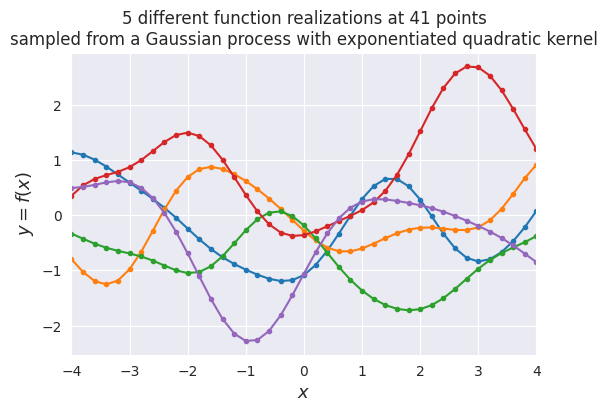

In [178]:
# Plot the sampled functions
plt.figure(figsize=(6, 4), dpi=100)
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()

### Gaussian processes for regression

Since Gaussian processes model distributions over functions we can use them to build regression models. 
We can treat the Gaussian process as a prior defined by the kernel function and create a posterior distribution given some data. 

This posterior distribution can then be used to predict the expected value and probability of the output variable $y$ given input variables $X$.

### Noise-free predictions from posterior 

Given a training dataset with noise-free function values $\mathbf{f}$ at inputs $\mathbf{X}$, a GP prior can be converted into a GP posterior $p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{f})$ which can then be used to make predictions $\mathbf{f}_*$ at new inputs $\mathbf{X}_*$. By definition of a GP, the joint distribution of observed values $\mathbf{f}$ and predictions $\mathbf{f}_*$ is again a Gaussian which can be partitioned into

$$
\begin{pmatrix}\mathbf{f} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{2}\label{eq2}
$$

where $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$. With $N$ training data and $N_*$ new input data $\mathbf{K}$ is a $N \times N$ matrix, $\mathbf{K}_*$ a $N \times N_*$ matrix and $\mathbf{K}_{**}$ a $N_* \times N_*$ matrix. Using standard rules for conditioning Gaussians, the predictive distribution is given by 

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{f}) &= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{3}\label{eq3} \\
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{f}\tag{4}\label{eq4} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*\tag{5}\label{eq5}
\end{align*}
$$

### In-depth

We want to make predictions $\mathbf{y}_2 = f(X_2)$ for $n_2$ new samples, and we want to make these predictions based on our Gaussian process prior and $n_1$ previously observed data points $(X_1,\mathbf{y}_1)$. This can be done with the help of the posterior distribution $p(\mathbf{y}_2 \mid \mathbf{y}_1,X_1,X_2)$. Keep in mind that $\mathbf{y}_1$ and $\mathbf{y}_2$ are [jointly Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Joint_normality) since they both come from the same multivariate distribution. Since they are jointly Gaussian and we have a finite number of samples we can write: 

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right)
$$

Where:
$$\begin{split}
\mu_{1} & = m(X_1) \quad (n_1 \times 1) \\
\mu_{2} & = m(X_2) \quad (n_2 \times 1) \\
\Sigma_{11} & = k(X_1,X_1) \quad (n_1 \times n_1) \\
\Sigma_{22} & = k(X_2,X_2) \quad (n_2 \times n_2) \\
\Sigma_{12} & = k(X_1,X_2) = k_{21}^\top \quad (n_1 \times n_2)
\end{split}$$

Note that $\Sigma_{11}$ is independent of $\Sigma_{22}$ and vice versa.

We can then get the conditional distribution:

$$\begin{split}
p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
          & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \quad (\text{if assume mean prior }  \mu = 0 ) \\
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12}
\end{split}$$

We can write these as follows (Note here that $\Sigma_{11} = \Sigma_{11}^{\top}$ since it's [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix).):

$$\begin{array}{cc}
\begin{split}
\mu_{2|1} & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \\
          & = (\Sigma_{11}^{-1} \Sigma_{12})^{\top}  \mathbf{y}_1 \\
\end{split}
& \qquad
\begin{split}
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12} \\
             & = \Sigma_{22} - (\Sigma_{11}^{-1} \Sigma_{12})^{\top} \Sigma_{12} \\
\end{split}
\end{array}$$



It is then possible to predict $\mathbf{y}_2$ corresponding to the input samples $X_2$ by using the mean $\mu_{2|1}$ of the resulting distribution as a prediction. 
Notice that the mean of the posterior predictions $\mu_{2|1}$ of a Gaussian process are weighted averages of the observed variables $\mathbf{y}_1$, where the weighting is based on the covariance function $k$. The variance $\sigma_2^2$ of these predictions is then the diagonal of the covariance matrix $\Sigma_{2|1}$.

The Gaussian process posterior is implemented in the `GP` method below. We can compute the $\Sigma_{11}^{-1} \Sigma_{12}$ term with the help of Scipy's [`solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) function. 

In [179]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2

The code below calculates the posterior distribution based on 8 observations from a sine function. The results are plotted below. The top figure shows the distribution where the red line is the posterior mean, the shaded area is the 95% prediction interval, the black dots are the observations $(X_1,\mathbf{y}_1)$.
The prediction interval is computed from the standard deviation $\sigma_{2|1}$, which is the square root of the diagonal of the covariance matrix. The bottom figure shows 5 realizations (sampled functions) from this distribution.  

Note that the distribution is quite confident of the points predicted around the observations $(X_1,\mathbf{y}_1)$, and that the prediction interval gets larger the further away it is from these points.

In [180]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1,1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1,1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, kernel_rbf)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

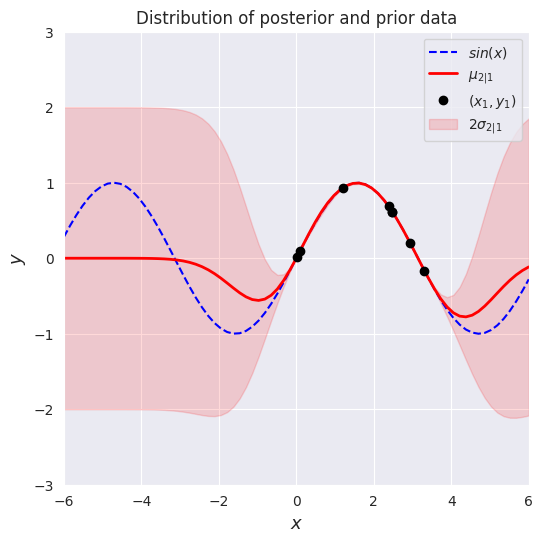

In [181]:
def plot_gp(X_train, y_train, X_test, μ_pred, cov_std_pred, title="Distribution of posterior and prior data"): 
    fig, ax1 = plt.subplots(
        nrows=1, ncols=1, figsize=(6, 6), dpi=100)
    # Plot the distribution of the function (mean, covariance)
    ax1.plot(X_test, f_sin(X_test), 'b--', label='$sin(x)$')
    ax1.fill_between(X2.flat, μ_pred-2*cov_std_pred, μ_pred+2*cov_std_pred, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
    ax1.plot(X_test, μ_pred, 'r-', lw=2, label='$\mu_{2|1}$')
    ax1.plot(X_train, y_train, 'ko', linewidth=2, label='$(x_1, y_1)$')
    ax1.set_xlabel('$x$', fontsize=13)
    ax1.set_ylabel('$y$', fontsize=13)
    ax1.set_title(title)
    ax1.axis([domain[0], domain[1], -3, 3])

    ax1.legend()
    
plot_gp(X1, y1, X2, μ2, σ2)

(-6.0, 6.0)

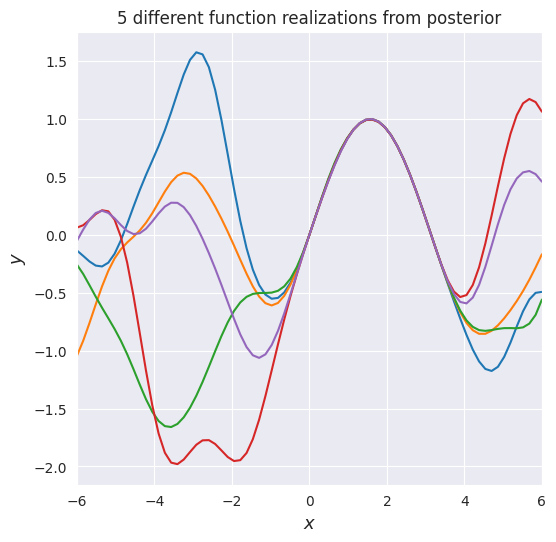

In [182]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6), dpi=100)

# Plot some samples from this function
ax1.plot(X2, y2.T, '-')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('5 different function realizations from posterior')
ax1.set_xlim([-6, 6])

### Noisy observations

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can notice this in the plot above because the posterior variance becomes zero at the observations $(X_1,\mathbf{y}_1)$.
We can make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as Gaussian noise with variance $\sigma_\epsilon^2$.

This noise can be modelled by adding it to the covariance kernel of our observations:

$$
\Sigma_{11} = k(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independently distributed). The Gaussian process posterior with noisy observations is implemented in the `GP_noise` method below.

In [183]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1, l, sigma_f) + ((sigma_y ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, l, sigma_f)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, l, sigma_f)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [184]:
# Compute the posterior mean and covariance

σ_noise = 0.4  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((σ_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, kernel_rbf, sigma_y=σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

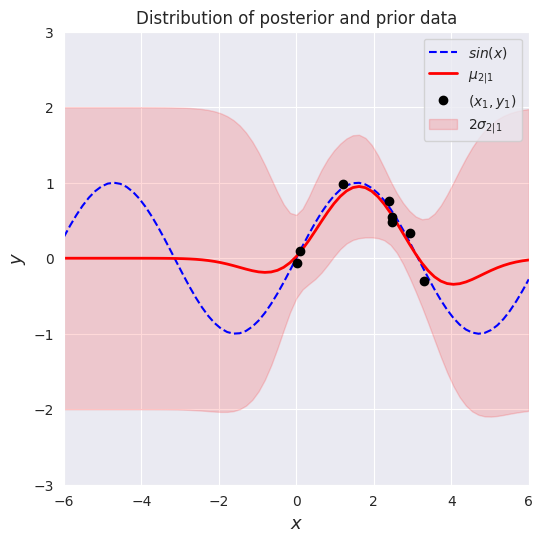

In [185]:
plot_gp(X1, y1, X2, μ2, σ2)

(-6.0, 6.0)

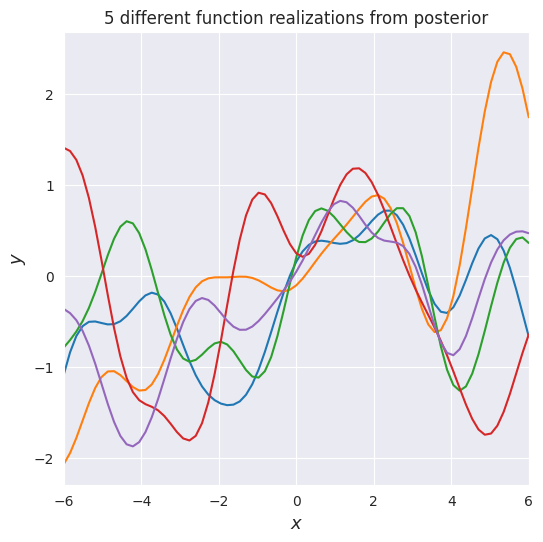

In [186]:
# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6,6), dpi=100)
# Plot some samples from this function
ax1.plot(X2, y2.T, '-')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('5 different function realizations from posterior')
ax1.set_xlim([-6, 6])

### Effect of kernel parameters and noise parameter

The following example shows the effect of kernel parameters $l$ and $\sigma_f$ as well as the noise parameter $\sigma_y$. Higher $l$ values lead to smoother functions and therefore to coarser approximations of the training data. Lower $l$ values make functions more wiggly with wide uncertainty regions between training data points. $\sigma_f$ controls the vertical variation of functions drawn from the GP. This can be seen by the wide uncertainty regions outside the training data region in the right figure of the second row. $\sigma_y$ represents the amount of noise in the training data. Higher $\sigma_y$ values make more coarse approximations which avoids overfitting to noisy data.

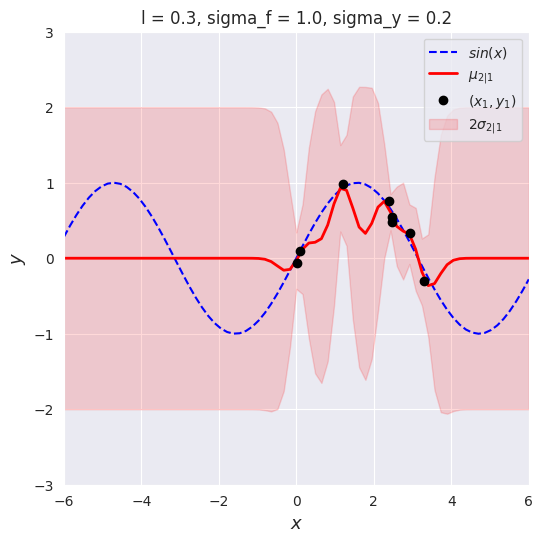

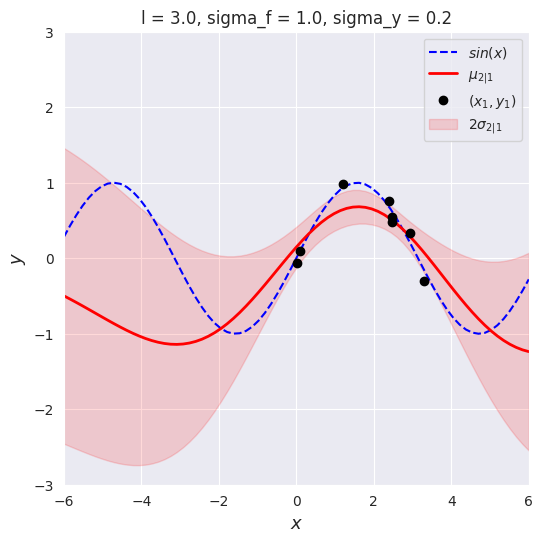

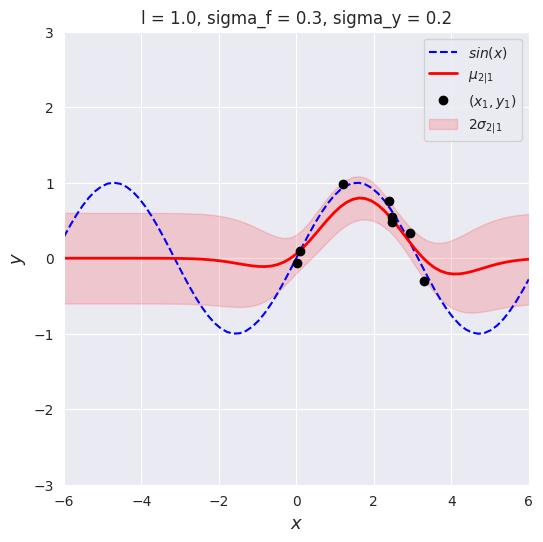

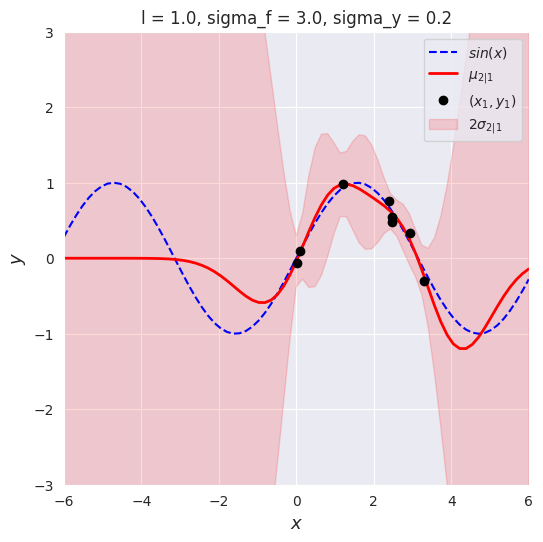

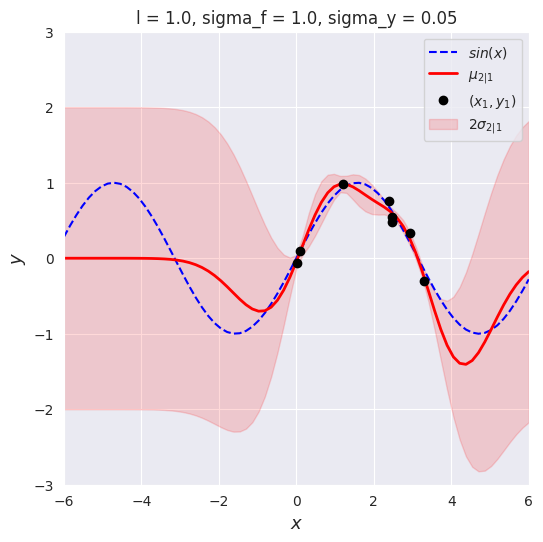

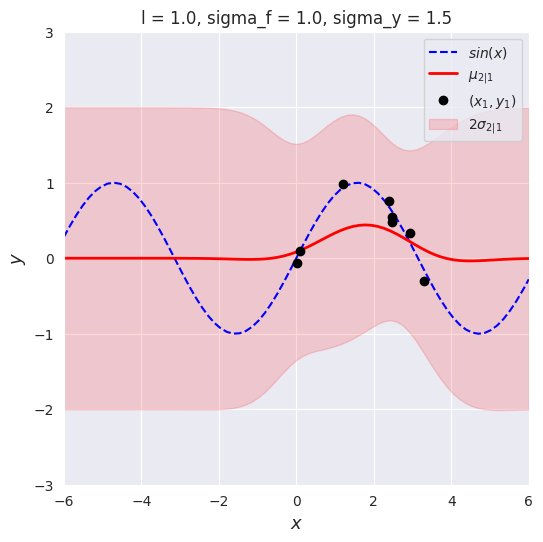

In [187]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]


for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = GP_noise(X1, y1, X2, kernel_rbf, l=l, 
                            sigma_f=sigma_f, 
                            sigma_y=sigma_y)
    cov_std = np.sqrt(np.diag(cov_s))

    plot_gp(X1, y1, X2, mu_s, cov_std, title=f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood which is given by

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{11}
$$

In the following we will minimize the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$, $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, $\sigma_y$ can be estimated as well along with the other parameters. 

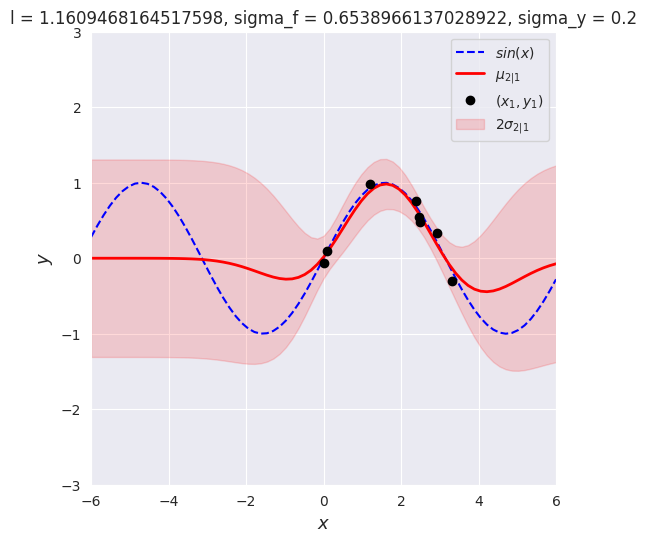

In [188]:
from numpy.linalg import cholesky, det
from numpy.linalg import inv
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, kernel=kernel_rbf, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
noise = 0.2
res = minimize(nll_fn(X1, y1, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = GP_noise(X1, y1, X2, kernel_rbf, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
cov_std = np.sqrt(np.diag(cov_s))

plot_gp(X1, y1, X2, mu_s, cov_std, title=f'l = {l_opt}, sigma_f = {sigma_f_opt}, sigma_y = {noise}')

Key points to take away are:

-    A Gaussian process is a distribution over functions fully specified by a mean and covariance function.
-    Every finite set of the Gaussian process distribution is a multivariate Gaussian.
-    The posterior predictions of a Gaussian process are weighted averages of the observed data where the weighting is based on the coveriance and mean functions.


## References

1. https://bigaidream.gitbooks.io/subsets_ml_cookbook/content/bayes/gp/gp_code_scratch.html
2. http://krasserm.github.io/2018/03/19/gaussian-processes/
3. https://peterroelants.github.io/posts/gaussian-process-tutorial/